In [29]:
import json
import gensim
import matplotlib.pyplot as plt
import numpy as np
from pattern.en import parse
from pattern.en import tag as ptag
import string
import tsne  # local copy in the repo

In [11]:
%matplotlib inline

### The stuff for processing all the book files

In [86]:
sample_parsed = parse("He is a text sample showing you what happens when you use this function for her.", 
   tokenize = True,         # Split punctuation marks from words?
       tags = True,         # Parse part-of-speech tags? (NN, JJ, ...)
     chunks = False,        # Parse chunks? (NP, VP, PNP, ...)
  relations = False,         # Parse chunk relations? (-SBJ, -OBJ, ...)
    lemmata = False,        # Parse lemmata? (ate => eat)
   encoding = 'utf-8',      # Input string encoding.
     tagset = None)

In [87]:
# just showing you what it looks like
sample_parsed

u'He/PRP is/VBZ a/DT text/NN sample/NN showing/VBG you/PRP what/WP happens/VBZ when/WRB you/PRP use/VB this/DT function/NN for/IN her/PRP ./.'

In [59]:
""" A bunch of functions that do text cleanup and create the strings of nouns for the model training."""

def tag_by_line(line, tags):
    """ Look for only the words with those tags """
    words = []
    #print ptag(line)
    for word, foundtag in ptag(line):
        if foundtag in tags:
            words.append(word)
    return words

def cleanup(text):
    """ This function cleans up the text a bit, and removes newlines. """
    data = text.decode('utf8')
    data = data.replace('\r', '')  # windows newline in some files
    data = data.replace('\n', ' ')  # turn newline into space
    data = data.replace('_', '')
    data = data.replace('--', ' -- ')
    data = data.replace(',', ' ')
    data = data.replace('.', ' ')
    data = data.strip()  # strip remaining white space chars from edges
    return data


def cleanup_and_pos(text, pos=['NN']):
    """ 
    Run the cleanup function, convert to a list of tag types, clean out misc stuff left.
    Also converts back to a space sep string of the text we want in the model/output only
    """
    # put your own list of strings here, based on reading outputs:
    other_things_to_strip = ['s', '\'s', 'n\'t', '\'ll', 'chapter', 'CHAPTER']
    
    data = cleanup(text)
    words = tag_by_line(data, pos)   # returns a list of words of that POS (part of speech)
    cleantext = [word.lower() for word in words if word not in string.punctuation]
    cleantext = [word for word in cleantext if word not in other_things_to_strip]
    newdata = ' '.join(cleantext)  # make it a single string, the model likes that
    return newdata

In [60]:
"""
Model text generator - based on Radim's sample code for gensim.
This produces a line at a time of cleaned, tag-only text for the model to train from.
"""
 
import os
import re

class MySentences(object):
    def __init__(self, dirname, tags=['NN']):
        self.dirname = dirname
        self.tags = tags
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            for line in open(os.path.join(self.dirname, fname)):
                yield (cleanup_and_pos(line, pos=self.tags)).split()

In [228]:
""" An alternate from gensim tutorials - just use all words in the model. """

class DirOfPlainTextCorpus(object):
    """Iterate over sentences of all plaintext files in a directory """
    SPLIT_SENTENCES = re.compile(u"[.!?:]\s+")  # split sentences on these characters

    def __init__(self, dirname):
        self.dirname = dirname

    def __iter__(self):
        for fn in os.listdir(self.dirname):
            text = open(os.path.join(self.dirname, fn)).read()
            for sentence in self.SPLIT_SENTENCES.split(text):
                yield gensim.utils.simple_preprocess(sentence, deacc=True)

In [241]:
### updates datadict, uses model, tags, writes labeled txt file out

def clean_dict_keys(datadict):
    """ Removes words that make bad keys/nouns for the word swaps. """
    for key in datadict.keys():
        if key == 'xi':
            datadict.pop(key, None)
        if ',' in key:
            datadict.pop(key, None)
            continue
        if '--' in key:
            datadict.pop(key, None)
            continue
        if 'xx' in key:
            datadict.pop(key, None)
            continue
        if 'xv' in key:
            datadict.pop(key, None)
            continue
        if '\n' in key:
            datadict.pop(key, None)
            continue
        if '.' in key:
            datadict.pop(key, None)
            continue
    return datadict

def cap_me(word, capflag):
    """ Capitalizes the word if it was in the original text """
    if capflag:
        return word.capitalize()
    else:
        return word

def build_dict_write_file(model, outputtextfile, outputdatafile, tags=['NN']):
    """ Writes out the labeled text with word swaps, returns datadict """
    
    screen_outs = ['CHAPTER', 'chapter', 'Chapter', '', ',', 'xi']  # too common and not useful
    datadict = {}
    
    print tags
    
    with open('books/austen_pride.txt', 'r') as handle:
        lines = handle.read()
        lines = lines.split('\n\r')
        full_text = ''
        for sample in lines:
            new = sample.replace('\n\r',' ')
            new = new.replace('_', '')
            new = new.replace(',', ', ')
            new = new.replace('--', ' -- ')
            line = parse(new, 
               tokenize = True,     # Split punctuation marks from words?
               tags = True,         # Parse part-of-speech tags? (NN, JJ, ...)
             chunks = False,        # Parse chunks? (NP, VP, PNP, ...)
          relations = False,        # Parse chunk relations? (-SBJ, -OBJ, ...)
            lemmata = False,        # Parse lemmata? (ate => eat)
           encoding = 'utf-8',      # Input string encoding.
             tagset = None)
            line = line.replace('\n', ' ')
            sample_spaced = line.split(' ')
            line_text = '<p>'
            for word in sample_spaced:
                capFlag = False
                newWord = word
                word = word.replace('\n', ' ')
                if word.strip() == '':
                    continue
                bits = word.split('/')
                if len(bits) == 2:
                    if bits[1] in tags and bits[0] not in screen_outs:
                        if bits[0][0] in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":  # check for first cap
                            capFlag = True
                        
                        try:
                            # best match for original word
                            best = model.most_similar(positive=[bits[0].lower()], negative=[], topn=1)   # (word, score)
                            if best[0][0].strip() in screen_outs:
                                raise 'WordError'
                            # add original word to datadict, with best match as word for it
                            datadict[bits[0].lower().encode('utf8')] = {"word": best[0][0].lower(), 
                                                                        "score": "%.3f" % best[0][1]}
                            # add the reverse word to the same dict, for graphing in front end
                            best_reverse = model.most_similar(positive=[best[0][0]], negative=[], topn=1)
                            if best_reverse[0][0] in screen_outs:
                                raise 'WordError'
                            datadict[best[0][0].lower().encode('utf8')] = {"word": best_reverse[0][0].lower(), 
                                                                           "score": "%.3f" % best_reverse[0][1]}
                            newWord = '<span class="color" title="Was: <span class=\'purple\'>'\
                                    + bits[0] + '</span> / Word2Vec similarity: ' + str(round(best[0][1],3))\
                                    + '" formerWord="' + bits[0].lower() + '" newWord="' + best[0][0].lower() + '" score="'\
                                    + str(round(best[0][1],3)) + '">' + cap_me(best[0][0],capFlag) + '</span>'
                            line_text += newWord
                        except Exception, e:  # on model errors etc, just continue past it
                            print e
                            line_text += word.replace('/NN', '')
                            pass
                    
                    else:
                        if bits[0] in [',',':','.','"',';','?', '!', '\'s', '\'ll', 'n\'t']:
                            line_text = line_text.strip() # remove spaces before these
                        line_text += bits[0]
                    if line_text[-1] != '"':  # no space after quotes; hacky.
                        line_text += ' '
                else:
                    if word.strip() != '':
                        line_text += word.strip()
            full_text += line_text + '\n'

    print "vocab before clean", datadict.keys()
    datadict = clean_dict_keys(datadict)
    print "vocab after clean", datadict.keys()
    
    with open(outputtextfile, 'w') as handle:
        handle.write(full_text.encode('utf8'))
    jsonfile = json.dumps(datadict)
    with open(outputdatafile, 'w') as handle:
        handle.write(jsonfile)

    print "Wrote out to data directory:", outputtextfile, outputdatafile
    return datadict

In [242]:
# The wrapper function that runs everything, writes files, and returns useful things.
def run_all(tags=['NN'], filepref='data/pride_NN'):
    
    # notice here i require at least 2 uses of each word in the corpus - reduces noise
    
    # uncomment the version of the model you want to try: tag limited, or all words.
    #model = gensim.models.Word2Vec(MySentences('books', tags=tags), min_count=2, size=200, workers=2)
    model = gensim.models.Word2Vec(DirOfPlainTextCorpus('books'), min_count=3, workers=2)
    model.save(filepref + '_model_austen_allwordsmin3')
    
    # if you want to save time and use a saved file, comment out the above and uncomment this with right path
    #model = gensim.models.Word2Vec.load('data/pride_NNPRP_model_austen_all')
    
    # does the text tagging and word replacement
    print tags
    datadict = build_dict_write_file(model, filepref + '_labeled.txt', filepref + '_data.json', tags=tags)
    
    # tsne input files part
    make_score_files(model, datadict, filepref)
    
    # the actual tsne graph bit
    X = np.loadtxt(filepref + "_scores.csv")
    labels = np.genfromtxt(filepref + "_words.csv", dtype=str)
    Y = tsne.tsne(X, 2, 50, 20.0)   # see tsne.py in repo
    do_tsne_files(filepref + '_coords.tsv', Y, labels, datadict, axis_off=True)
    
    return Y, labels, datadict, model

In [ ]:
# run it all together and get the useful outputs - this takes a while and prints a lot of stuff.
Y, labels, datadict, model = run_all(tags=['NN'], filepref='data/pride_NNAll3')

#### Do the file splitting part for the UI - Make sure to rename the label file for the output

In [234]:
!split -l 200 data/pride_NNAll3_labeled.txt part

In [235]:
%%bash
mv partaa data/parts/part1.txt
mv partab data/parts/part2.txt
mv partac data/parts/part3.txt
mv partad data/parts/part4.txt
mv partae data/parts/part5.txt
mv partaf data/parts/part6.txt
mv partag data/parts/part7.txt
mv partah data/parts/part8.txt
mv partai data/parts/part9.txt
mv partaj data/parts/part10.txt
mv partak data/parts/part11.txt
mv partal data/parts/part12.txt

In [236]:
ls data/parts

part1.txt   part11.txt  part2.txt   part4.txt   part6.txt   part8.txt
part10.txt  part12.txt  part3.txt   part5.txt   part7.txt   part9.txt


#### Play with your model if you want... 

In [232]:
model.most_similar(['husband'])

[(u'nerves', 0.8918779492378235),
 (u'lifting', 0.7963227033615112),
 (u'wishes', 0.7679949998855591),
 (u'nephew', 0.7674976587295532),
 (u'senses', 0.7639766931533813),
 (u'daughter', 0.7601332664489746),
 (u'ladyship', 0.7527087330818176),
 (u'daughters', 0.7525165677070618),
 (u'thoughts', 0.7426179647445679),
 (u'mother', 0.7310776710510254)]

In [231]:
model.most_similar(['wife'])

[(u'son', 0.7893723249435425),
 (u'reviving', 0.7113327980041504),
 (u'daughter', 0.7054953575134277),
 (u'admittance', 0.6823280453681946),
 (u'attentions', 0.658092737197876),
 (u'warmed', 0.6542254090309143),
 (u'niece', 0.6514275074005127),
 (u'addresses', 0.6490938663482666),
 (u'proposals', 0.647223174571991),
 (u'behaviour', 0.6413060426712036)]

### TSNE Plotting Stuff

In [35]:
# for tsne - write out the scores and labels as 2 row syncd files - can be used in R now.

def make_score_files(model, datadict, filelabel):
    with open(filelabel + '_scores.csv', 'w') as scorefile:
        with open(filelabel + '_words.csv', 'w') as wordfile:
            for word in datadict.keys():
                try:
                    score = model[word.lower()]
                    scores = [str(x) for x in score]
                    scorefile.write('\t'.join(scores) + '\n')
                    wordfile.write(word.lower() + '\n')
                except:
                    print "Not found:", word, datadict[word]
                    continue
            scorefile.write('\n')
            wordfile.write('\n')
    print 'Wrote ', scorefile, wordfile

In [52]:
!paste data/pride_NN_words.csv data/pride_NN_scores.csv > data_for_r.tsv

#### The scores and words csv files you just wrote out can be used in the R code in the repo, if you want to try that for the plot instead.

In [204]:
# this is a function you can call independently with output from your run-all run, to jigger with details if you want.

def do_tsne_files(coordsfilename, Y, labels, datadict, axis_off=True):
    """ Makes the tsne grah file and writes out the coords for the UI. """
    plt.figure(figsize=(15, 15))
    if axis_off:
        plt.axis('off')   # only turn off after checking the axis min/max
    plt.scatter(Y[:,0], Y[:,1], s=10, color='gray', alpha=0.2)
    print "X and Y dims ", plt.axis()
    with open(coordsfilename, 'w') as handle1:
        handle1.write('word\tx\ty\tnearest\n')
        for label, x, y in zip(labels, Y[:, 0], Y[:, 1]):
            score = datadict[label]['score']
            handle1.write('\t'.join([label, str(x), str(y), str(score)]) + '\n')
            #plt.text(x, y, label, size=8, alpha=0.5)
    print "wrote out", coordsfilename

X and Y dims  (-150.0, 150.0, -150.0, 150.0)
wrote out misc.tsv


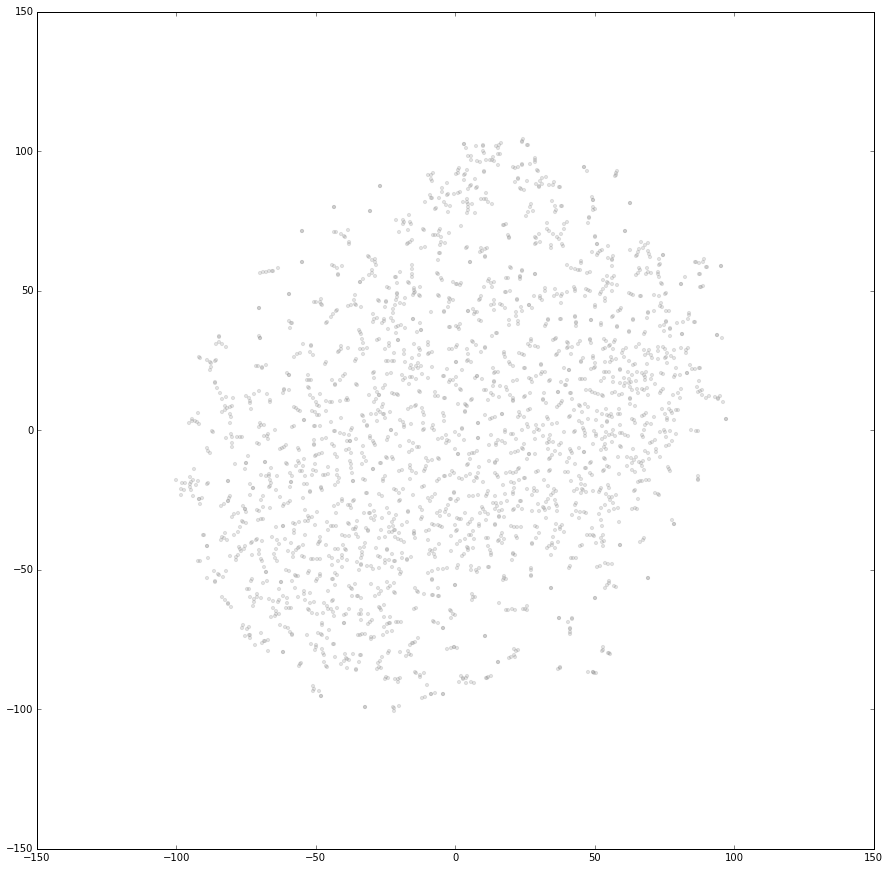

In [246]:
do_tsne_files('misc.tsv', Y, labels, datadict, axis_off=False)   # run this again with axis on, to check axes limits for the graph...